# Interpreting our Taxi Time Predicion Machine Learning Models

In this notebook we use **Skater**, a unified framework for Model Interpretation, to demystify the learned structures of our taxi time prediction models both globally (inference on the basis of a complete data set) and locally (inference about an individual taxi time predictions).

## Loading the data

In [161]:
# Importing the necessary packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from sklearn.model_selection import train_test_split

In [163]:
# Loading the dataset
df = pd.read_csv("clean_training_set_vf.csv")
pd.set_option('display.max_columns', None)

In [164]:
# Spliting into train and test
df_y = df['taxitime']
df_X = df.drop(['taxitime'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
     df_X, df_y, test_size=0.2, random_state=42)

In [165]:
X_train.head()

,aircraft_model,AOBT,Stand,Runway,Manufacturer,Engines,Wingspan__ft,Length__ft,Tail_Height__ft,Wheelbase__ft,Wake_Category,runway_stand,distance,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,precipAccumulation,ozone,log_distance,N,Q,hour,month,quarter,off-peak_hour,hour_sin,hour_cos,month_sin,month_cos,quarter_sin,quarter_cos,i_clear-day,i_clear-night,i_cloudy,i_fog,i_partly-cloudy-day,i_partly-cloudy-night,i_rain,i_snow,i_wind,pt_None,pt_rain,pt_snow,avg_manuf
47621,A319,2015-05-27 08:02:00,STAND_54,RUNWAY_4,Airbus,2.0,111.88,111.020000,39.730000,36.230000,2,RUNWAY_4STAND_54,406.099037,Clear,clear-day,0.0,0.0,48.26,47.23,41.00,0.76,1026.2,3.54,4.11,328.0,0.30,1.0,6.216,None,0.0,310.4,6.006597,4,3,8,5,2,0,0.866025,-0.500000,0.500000,-0.866025,1.224647e-16,-1.000000e+00,1,0,0,0,0,0,0,0,0,1,0,0,18.317737
219762,A319,2016-08-29 11:06:00,STAND_45,RUNWAY_4,Airbus,2.0,111.88,111.020000,39.730000,36.230000,2,RUNWAY_4STAND_45,1125.249135,Partly Cloudy,partly-cloudy-day,0.0,0.0,62.65,62.75,59.00,0.88,1022.0,2.75,5.58,349.0,0.44,3.0,6.216,None,0.0,310.4,7.025760,7,5,11,8,3,0,0.258819,-0.965926,-0.866025,-0.500000,-1.000000e+00,-1.836970e-16,0,0,0,0,1,0,0,0,0,1,0,0,18.317737
442717,A319,2018-05-03 15:16:00,STAND_152,RUNWAY_4,Airbus,2.0,111.88,111.020000,39.730000,36.230000,2,RUNWAY_4STAND_152,1194.419641,Partly Cloudy,partly-cloudy-day,0.0,0.0,59.05,59.05,41.00,0.51,1019.8,5.82,6.20,240.0,0.44,6.0,6.216,None,0.0,310.4,7.085416,7,6,15,5,2,0,-0.707107,-0.707107,0.500000,-0.866025,1.224647e-16,-1.000000e+00,0,0,0,0,1,0,0,0,0,1,0,0,18.317737
115094,A320-100/200,2015-11-11 16:47:00,STAND_30,RUNWAY_1,Airbus,2.0,111.88,123.270000,39.630000,41.470000,2,RUNWAY_1STAND_30,2738.054591,Mostly Cloudy,partly-cloudy-day,0.0,0.0,57.25,57.25,49.99,0.77,1021.1,10.29,10.29,230.0,0.75,0.0,6.216,None,0.0,310.4,7.915003,4,4,16,11,4,0,-0.866025,-0.500000,-0.500000,0.866025,-2.449294e-16,1.000000e+00,0,0,0,0,1,0,0,0,0,1,0,0,18.317737
471303,ERJ-195,2018-07-14 20:23:00,STAND_54,RUNWAY_3,Embraer,2.0,94.25,126.833333,34.583333,48.033333,2,RUNWAY_3STAND_54,485.248091,Clear,clear-day,0.0,0.0,77.05,77.05,55.40,0.47,1017.3,11.14,23.04,221.0,0.19,1.0,6.216,None,0.0,310.4,6.184660,4,4,20,7,3,0,-0.866025,0.500000,-0.500000,-0.866025,-1.000000e+00,-1.836970e-16,1,0,0,0,0,0,0,0,0,1,0,0,16.862097


In [166]:
y_train.head()

47621      8.0
219762    13.0
442717    16.0
115094    17.0
471303    11.0
Name: taxitime, dtype: float64

## Modeling

### XGBoost

In [167]:
import xgboost as xgb
features = ['Engines','Wingspan__ft', 'Length__ft', 'Tail_Height__ft', 'Wheelbase__ft','Wake_Category', 'distance','precipIntensity', 'precipProbability', 'temperature','apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed','windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility', 'precipAccumulation', 'ozone', 'log_distance', 'N', 'Q','hour', 'month', 'quarter', 'off-peak_hour', 'hour_sin', 'hour_cos','month_sin', 'month_cos', 'quarter_sin', 'quarter_cos', 'i_clear-day','i_clear-night', 'i_cloudy', 'i_fog', 'i_partly-cloudy-day','i_partly-cloudy-night', 'i_rain', 'i_snow', 'i_wind', 'pt_None','pt_rain', 'pt_snow', 'avg_manuf']
train = X_train[features]
test = X_test[features]

model_xgb = xgb.XGBRegressor( booster='gbtree', colsample_bytree=0.8, 
             importance_type='gain', learning_rate=0.1, max_depth=6, 
            min_child_weight=1, n_estimators=25, objective='reg:squarederror', 
            random_state=0, subsample=0.8, verbosity=0)

model_xgb.fit(train, y_train,
        eval_set=[(train, y_train), (test, y_test)],
        early_stopping_rounds=10,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=25,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=0)

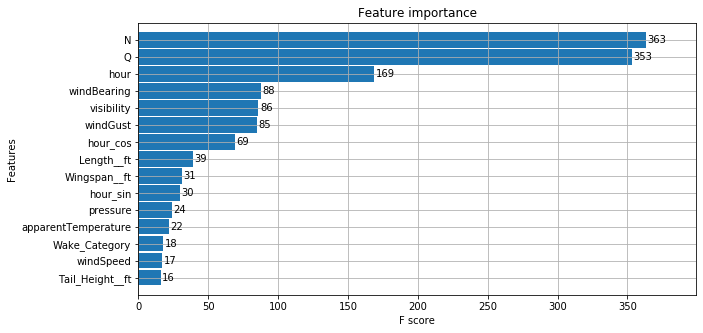

In [168]:
#Plot the features importance of the first 15 most importance features
fig, ax = plt.subplots(figsize=(10,5))
xgb.plot_importance(model_xgb, ax=ax, height=0.9, max_num_features=15)
plt.show()

In [169]:
#Predict on the test set
y_predict = model_xgb.predict(test)

In [170]:
y_test

412567    11.0
212579    15.0
441729    19.0
247100     9.0
407131    10.0
          ... 
365360    23.0
316640    22.0
437201    18.0
328428    41.0
138895    18.0
Name: taxitime, Length: 106706, dtype: float64

In [171]:
y_predict

array([10.355512, 16.052588, 15.62229 , ..., 14.728131, 30.70888 ,
       12.561436], dtype=float32)

In [172]:
from sklearn.metrics import mean_squared_error
from math import sqrt
#Compute Rmse
rmse = sqrt(mean_squared_error(y_test, y_predict))
rmse

3.528162759478714

### Random Forest

In [46]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(
         n_estimators=8, max_depth=10)

model_rf.fit(train, y_train)

predict_rf = model_rf.predict(test)

In [47]:
#Compute Rmse
rmse = sqrt(mean_squared_error(y_test, predict_rf))
rmse

3.223023598319087

In [82]:
train.head().month

47621      5
219762     8
442717     5
115094    11
471303     7
Name: month, dtype: int64

## SKATER Model Interpretation

In [173]:
# Importing Skater
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [174]:
# Creating an interpretation object 
interpreter = Interpretation(test, feature_names=features)
annotated_model = InMemoryModel(model_xgb.predict, examples=train)
print("Input shape: {}".format(annotated_model.input_shape))
print("Model Type: {}".format(annotated_model.model_type))

Input shape: (426820, 48)
Model Type: regressor


### Global Interpretation

**1. Feature importance**

[48/48] features ████████████████████ Time elapsed: 33 seconds

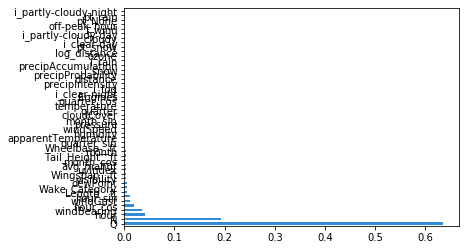

In [129]:
im_model = annotated_model
plots = interpreter.feature_importance.plot_feature_importance(im_model)

**2. Partial dependence plots**

[20/20] grid cells ████████████████████ Time elapsed: 0 seconds

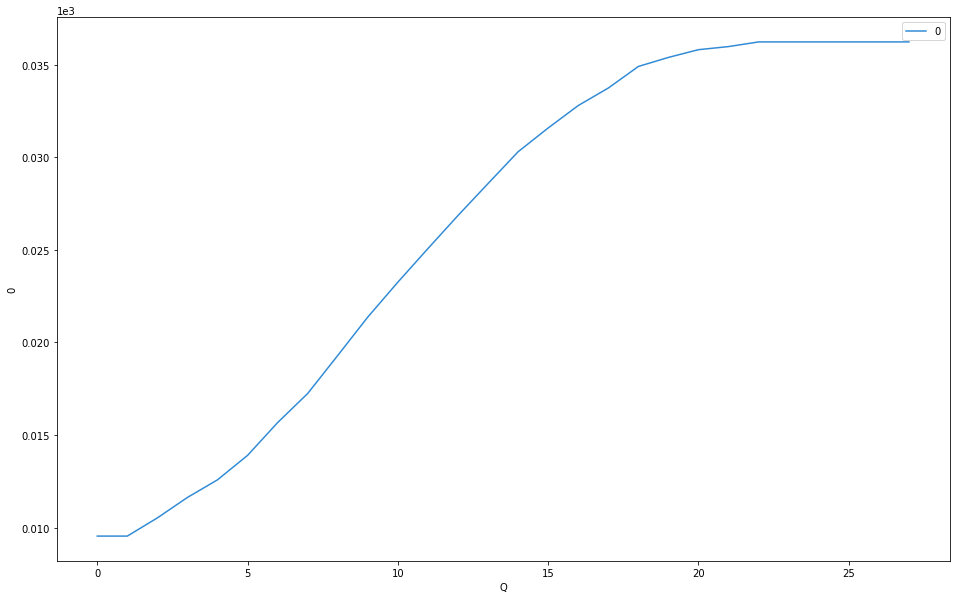

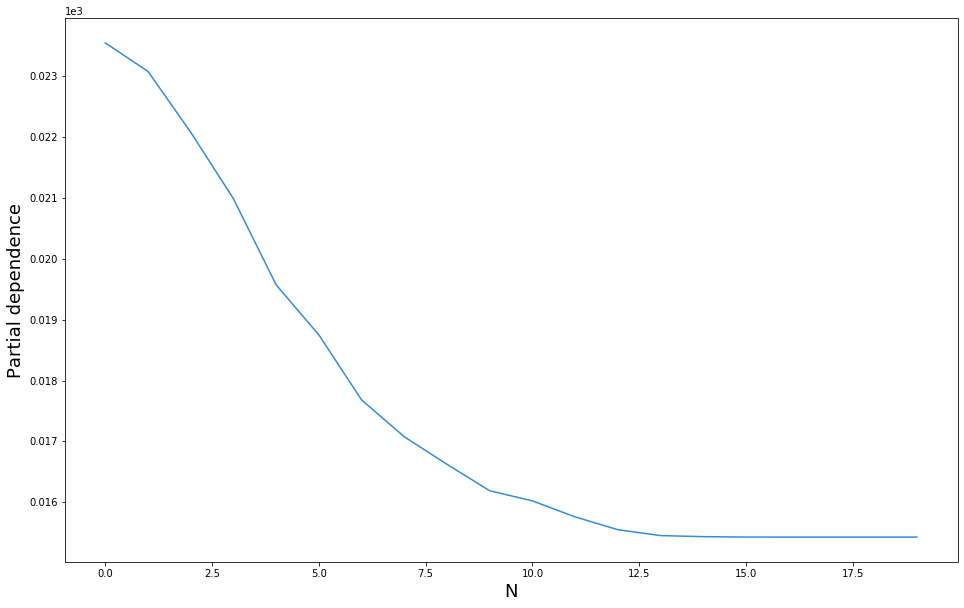

In [177]:
# 1-way partial dependence plots
from matplotlib.pyplot import figure
# from matplotlib.ticker import FormatStrFormatter
pdp_features = ['Q', 'N']
interpreter.partial_dependence.plot_partial_dependence(
    pdp_features, annotated_model, grid_resolution=30
)
plt.xlabel('N', fontsize=18)
plt.ylabel('Partial dependence', fontsize=18)
#plt.title('Partial dependence of taxitime on temperature', fontsize=18)
#plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # 2 decimal places
plt.legend('',frameon=False)

[560/560] grid cells ████████████████████ Time elapsed: 13 seconds

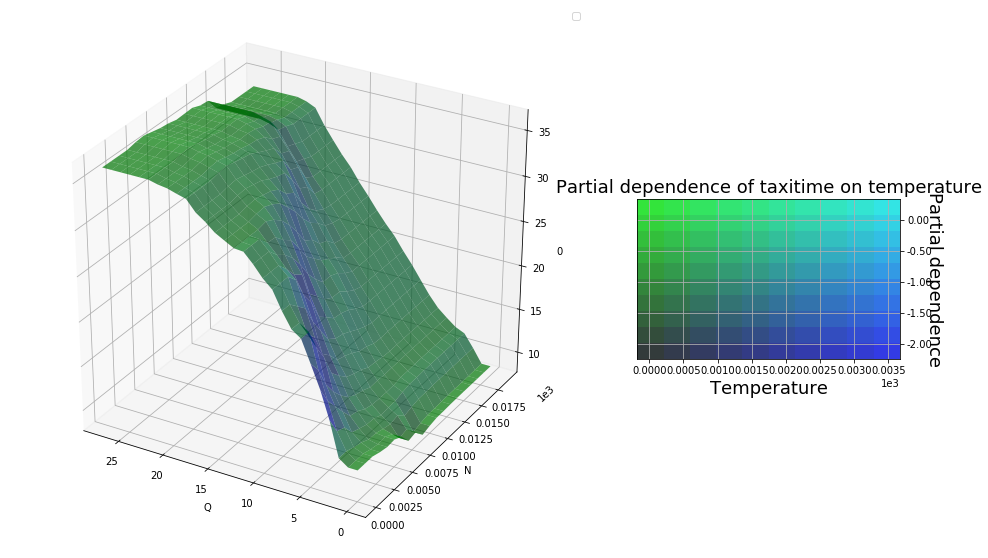

In [178]:
# 2-way partial dependence plots

#interpreter.load_data(train, feature_names=features)
pdp_features = [('Q', 'N')]
interpreter.partial_dependence.plot_partial_dependence(
    pdp_features, annotated_model, grid_resolution=30
)
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Partial dependence', fontsize=18)
plt.title('Partial dependence of taxitime on temperature', fontsize=18)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
plt.legend('',frameon=False)

### Local interpretation

In [150]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
features = ['Engines','Wingspan__ft', 'Length__ft', 'Tail_Height__ft', 'Wheelbase__ft','Wake_Category', 'distance','precipIntensity', 'precipProbability', 'temperature','apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed','windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility', 'precipAccumulation', 'ozone', 'log_distance', 'N', 'Q','hour', 'month', 'quarter', 'off-peak_hour', 'hour_sin', 'hour_cos','month_sin', 'month_cos', 'quarter_sin', 'quarter_cos', 'i_clear-day','i_clear-night', 'i_cloudy', 'i_fog', 'i_partly-cloudy-day','i_partly-cloudy-night', 'i_rain', 'i_snow', 'i_wind', 'pt_None','pt_rain', 'pt_snow', 'avg_manuf']
#features = ['Engines','Wingspan__ft', 'Length__ft', 'Tail_Height__ft', 'Wheelbase__ft','Wake_Category', 'distance','precipIntensity', 'precipProbability', 'temperature','apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed','windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility', 'precipAccumulation', 'ozone', 'log_distance', 'N', 'Q','hour', 'month', 'quarter', 'off-peak_hour', 'hour_sin', 'hour_cos','month_sin', 'month_cos', 'quarter_sin', 'quarter_cos', 'avg_manuf']
exp = LimeTabularExplainer(test.values, feature_names=features, mode='regression', class_names=['High taxi time', 'Low taxi time'])

In [155]:
example_nb = 300
print('Reference:', y_test.iloc[example_nb])
print('Predicted:', predict_rf[example_nb])
exp.explain_instance(test.iloc[example_nb].values, model_rf.predict).show_in_notebook()

Reference: 9.0
Predicted: 15.48082642249188
